# Projet 1: Système de Recommandation de Films Simplifié

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Prétraitement des données

In [2]:
# Charger les fichiers CSV
ratings = pd.read_csv('ratings.csv' ,nrows=1000001)     # userId, movieId, rating, timestamp
movies = pd.read_csv('movies.csv')       # movieId, title, genres

In [3]:
# Aperçu des données
print("Ratings:")
display(ratings.head(10))

print("\nMovies:")
display(movies.head(10))

Ratings:


,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119
5,1,381,3.5,1225734105
6,1,596,4.0,1225733524
7,1,1036,5.0,1225735626
8,1,1049,3.0,1225734079
9,1,1066,4.0,1225736961



Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
# Statistiques de base
print("\nNombre d'utilisateurs ayant noté des films :", ratings['userId'].nunique())
print("Nombre de films noté :", ratings['movieId'].nunique())
print("Nombre total de ratings :", len(ratings))


Nombre d'utilisateurs ayant noté des films : 9561
Nombre de films noté : 25825
Nombre total de ratings : 1000001


In [5]:
print("Nombre de valeures manquantes dans ratings")
display(ratings.isna().sum(axis=0))

print("Nombre de valeures manquantes dans movies")
display(movies.isna().sum(axis=0))

Nombre de valeures manquantes dans ratings


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Nombre de valeures manquantes dans movies


movieId    0
title      0
genres     0
dtype: int64

In [6]:
# Fusion sur 'movieId' pour avoir tout les films notés
ratings_merged = pd.merge(ratings[['userId', 'movieId', 'rating']], movies, on='movieId', how='inner')

display(ratings_merged.sample(10))

,userId,movieId,rating,title,genres
760796,7282,4823,4.0,Serendipity (2001),Comedy|Romance
233860,2377,300,4.0,Quiz Show (1994),Drama
68762,716,457,4.0,"Fugitive, The (1993)",Thriller
738106,7053,56333,3.5,"Savages, The (2007)",Comedy|Drama
791251,7612,1648,4.0,"House of Yes, The (1997)",Comedy|Drama
865805,8306,3793,3.0,X-Men (2000),Action|Adventure|Sci-Fi
776554,7440,3253,4.0,Wayne's World (1992),Comedy
28108,301,6953,5.0,21 Grams (2003),Crime|Drama|Mystery|Romance|Thriller
573878,5501,4344,4.0,Swordfish (2001),Action|Crime|Drama
449519,4305,3130,2.5,Bonfire of the Vanities (1990),Comedy|Crime|Drama


In [7]:
useri,frequsers=np.unique(ratings_merged.userId,return_counts=True)#useri les id des users, frequsers les freq de chaque user
itemi,freqitems=np.unique(ratings_merged.movieId,return_counts=True)#itemi les id des item, freqitem les freq de chaque item
n_users=len(useri)
n_items=len(itemi)
print("le nombre des utilisateurs est :"+ str(n_users) + " Et le nombre des items est: "+ str(n_items))

le nombre des utilisateurs est :9561 Et le nombre des items est: 25825


In [8]:
indice_user = pd.DataFrame()
indice_user["indice"]=range(1,len(useri)+1)
indice_user["useri"]=useri


indice_item = pd.DataFrame()
indice_item["indice"]=range(1,len(itemi)+1)
indice_item["itemi"]=itemi

In [9]:
#créer user_ID_new et Item_ID_new
x=[]
y=[]
for i in range(0,len(ratings_merged)):
    x.append((indice_user.indice[indice_user.useri==ratings_merged.userId[i]].axes[0]+1)[0])
    y.append((indice_item.indice[indice_item.itemi==ratings_merged.movieId[i]].axes[0]+1)[0])

In [10]:
ratings_merged["userId_new"]=x
ratings_merged["movieId_new"]=y

In [11]:
# Voir les doublons exacts
duplicates = ratings_merged.duplicated(subset=['userId_new', 'movieId_new'])
print("Doublons détectés :", duplicates.sum())

Doublons détectés : 0


In [12]:
# Supprimer les doublons en gardant le dernier (le plus récent selon l'ordre du DataFrame)
ratings_merged = ratings_merged.drop_duplicates(subset=['userId_new', 'movieId_new'], keep='last')

# Vérification
print("Nouveau nombre de doublons :", ratings_merged.duplicated(subset=['userId_new', 'movieId_new']).sum())


Nouveau nombre de doublons : 0


# Visualisations

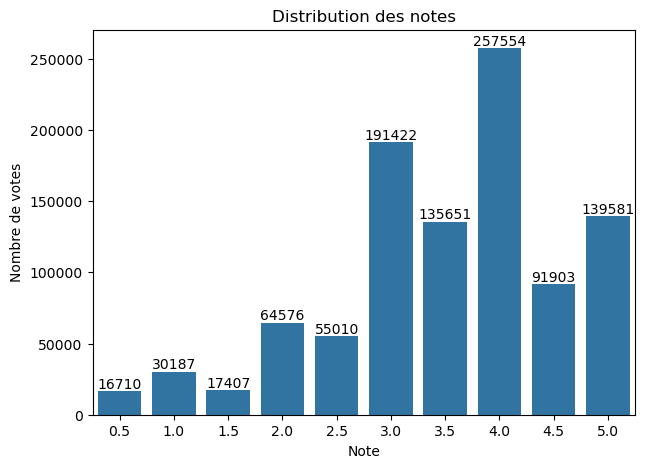

In [13]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='rating', data=ratings_merged)
plt.title("Distribution des notes")
plt.xlabel("Note")
plt.ylabel("Nombre de votes")

# Ajouter les valeurs au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

On se rend donc compte qu'il y a très peu de votes faibles mais beaucoup de votes forts **(principalement 4.0)**

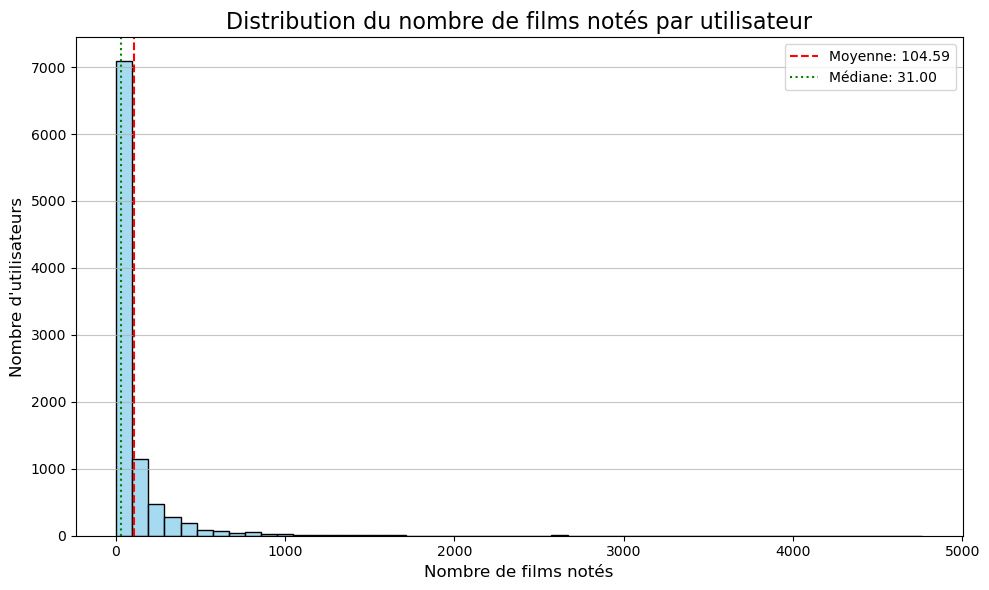

In [14]:
# Calcul de l'activité des utilisateurs (nombre de films notés par utilisateur)
user_activity = ratings_merged.groupby("userId_new")["movieId_new"].count()

plt.figure(figsize=(10, 6)) # Agrandir légèrement la figure pour une meilleure visibilité
sns.histplot(user_activity, bins=50, kde=False, color='skyblue', edgecolor='black') # Ajouter de la couleur et des bordures

plt.title("Distribution du nombre de films notés par utilisateur", fontsize=16) # Augmenter la taille du titre
plt.xlabel("Nombre de films notés", fontsize=12) # Étiquette plus descriptive et taille ajustée
plt.ylabel("Nombre d'utilisateurs", fontsize=12) # Taille ajustée

# Ajout de lignes ou de texte pour des informations clés (optionnel et contextuel)
# Par exemple, pour montrer la moyenne ou la médiane
mean_activity = user_activity.mean()
median_activity = user_activity.median()
plt.axvline(mean_activity, color='red', linestyle='--', label=f'Moyenne: {mean_activity:.2f}')
plt.axvline(median_activity, color='green', linestyle=':', label=f'Médiane: {median_activity:.2f}')
plt.legend() # Afficher la légende pour les lignes ajoutées

plt.grid(axis='y', alpha=0.75) # Ajout d'une grille pour faciliter la lecture
plt.tight_layout() # Ajuste automatiquement les paramètres de la figure pour qu'elle tienne dans la zone de dessin
plt.show()

Ce graphe traduit le fait que **très peu d'utilisateurs notent beaucoup de films**

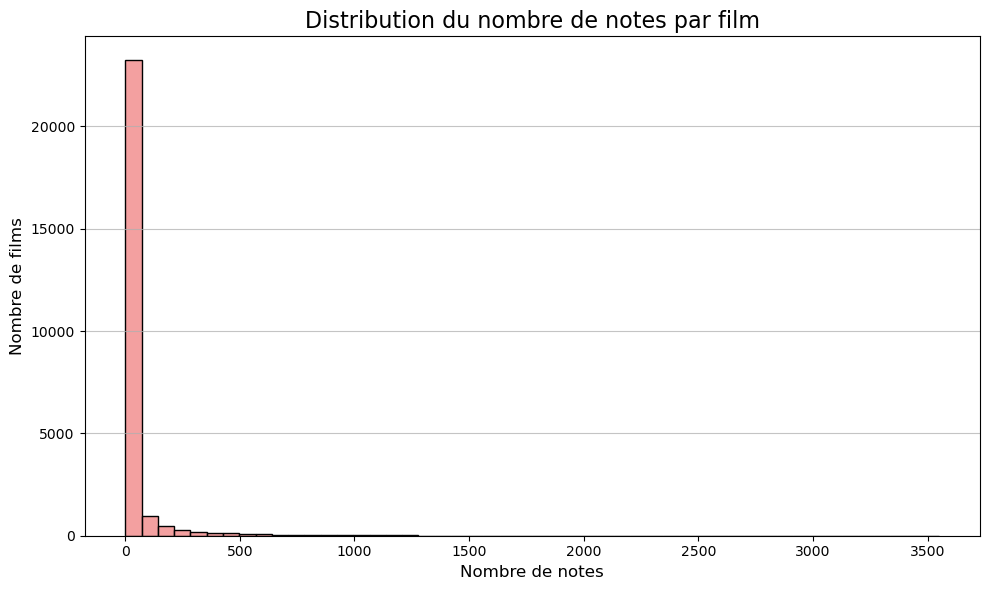

In [15]:
# Calculate movie popularity (number of ratings per movie)
movie_popularity = ratings_merged.groupby("movieId_new")["userId_new"].count()

plt.figure(figsize=(10, 6))  # Slightly increased figure height for better visual balance
ax = sns.histplot(movie_popularity, bins=50, kde=False, color='lightcoral', edgecolor='black') # Added color and distinct edges

plt.title("Distribution du nombre de notes par film", fontsize=16) # Clearer, larger title
plt.xlabel("Nombre de notes", fontsize=12) # Clearer label, adjusted size
plt.ylabel("Nombre de films", fontsize=12) # Adjusted label size

plt.grid(axis='y', alpha=0.75) # Added a subtle horizontal grid for easier reading
plt.tight_layout() # Ensures all elements fit snugly within the figure
plt.show()

Plusieurs films recoivent très peu de notes

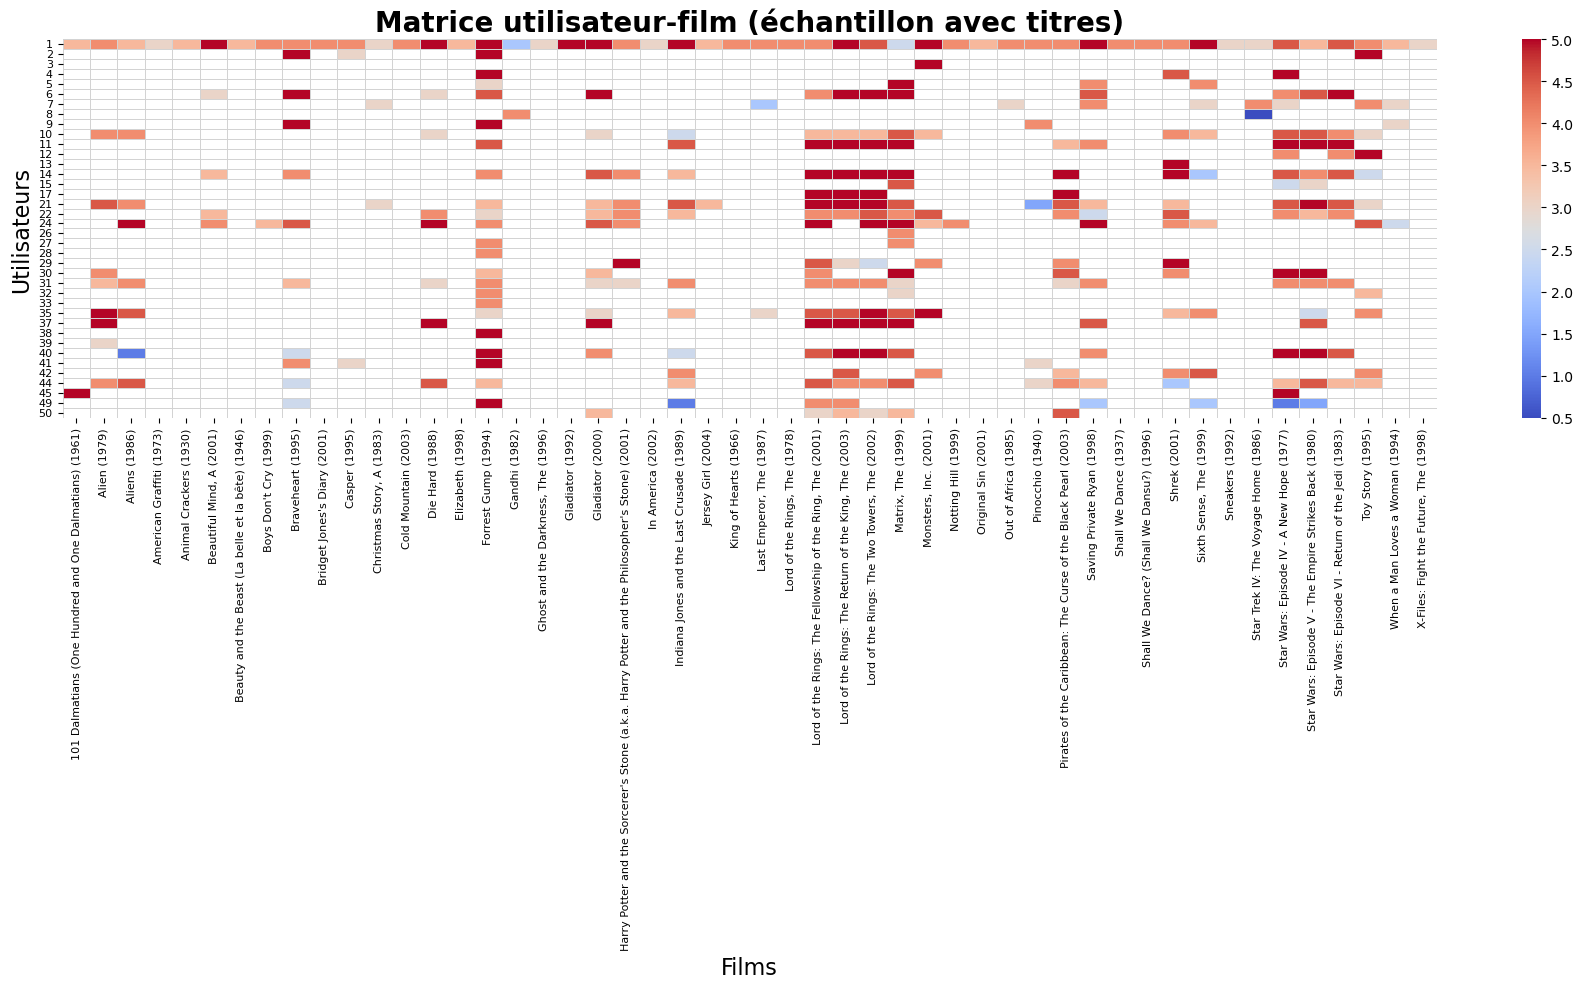

In [16]:
sample_df = ratings_merged[
    (ratings_merged['userId_new'].isin(ratings_merged['userId_new'].unique()[:50])) &
    (ratings_merged['movieId_new'].isin(ratings_merged['movieId_new'].unique()[:50]))
].copy() # Using .copy() to avoid SettingWithCopyWarning if you modify sample_df later


# --- La modification clé est ici : utiliser 'title' pour les colonnes ---
# Si 'title' est déjà dans sample_df, on peut directement l'utiliser comme colonnes.
pivot_sample = sample_df.pivot(index='userId_new', columns='title', values='rating')


plt.figure(figsize=(18, 10)) # Agrandir la figure pour mieux gérer les titres longs
sns.heatmap(pivot_sample,
            annot=False,       # Pas d'annotation numérique dans les cellules
            cmap="coolwarm",   # Conserver ta colormap originale
            cbar=True,         # Afficher la barre de couleur
            linewidths=.5,     # Ajouter de fines lignes entre les cellules pour la clarté
            linecolor='lightgray') # Couleur des lignes

plt.title("Matrice utilisateur-film (échantillon avec titres)", fontsize=20, fontweight='bold')
plt.xlabel("Films", fontsize=16)
plt.ylabel("Utilisateurs", fontsize=16)

# Rotation des étiquettes de l'axe X pour les titres de films afin d'éviter les chevauchements
plt.xticks(rotation=90, ha='center', fontsize=8) # Rotation à 90 degrés, alignement centré, taille de police ajustée
plt.yticks(rotation=0, fontsize=8) # Garder les étiquettes Y horizontales

# plt.legend() a été retiré car il n'est pas utilisé pour les éléments de cette heatmap.

plt.tight_layout() # Assure que tous les éléments s'ajustent bien dans la figure
plt.show()

De cet échantillon de la matrice user-item, on constate qu'il y a beaucoup plus de notes positives que négatives. Les espaces vides montrent juste que la plupart des 30 premiers utilisateurs n'ont pas tous notés les 30 premiers films. par contre si on utilisait toutes les lignes de notre dataframe, on aurait certe toutes les cellules colorées mais une matrice pratiquement illisible de part sa grandeur.

In [17]:
nb_users = ratings_merged['userId_new'].nunique()
nb_movies = ratings_merged['movieId_new'].nunique()
nb_ratings = len(ratings_merged)

sparsity = 1 - (nb_ratings / (nb_users * nb_movies))
print(f"Taux de sparsité : {sparsity:.4f} ({sparsity*100:.2f} %)")


Taux de sparsité : 0.9959 (99.59 %)


La sparsité est presque de 100% ce qui est normal et explique la raison pour laquelle un utilisateur ne peut pas noter ne serait ce que 1% des films.

C:\Users\Fred\AppData\Local\Temp\ipykernel_6436\1906502209.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_movies.index, x=top_movies.values, palette='viridis') # Added a color palette for aesthetics


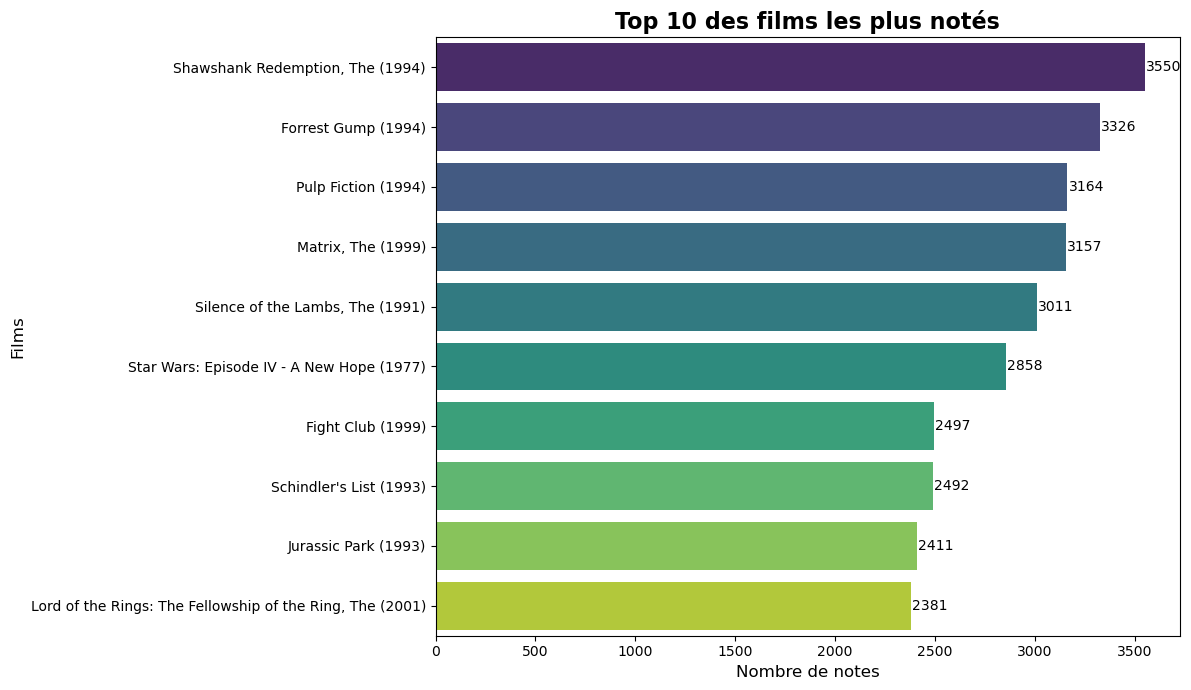

In [18]:
top_movies = ratings_merged['title'].value_counts().head(10)

plt.figure(figsize=(12, 7)) # Increased width for better label visibility
ax = sns.barplot(y=top_movies.index, x=top_movies.values, palette='viridis') # Added a color palette for aesthetics
plt.title("Top 10 des films les plus notés", fontsize=16, fontweight='bold')
plt.xlabel("Nombre de notes", fontsize=12)
plt.ylabel("Films", fontsize=12)

# Add values next to the bars for a horizontal bar plot
for p in ax.patches:
    # get_width() returns the width of the bar (which is the x-value in a horizontal plot)
    # get_y() returns the y-coordinate of the bottom of the bar
    # get_height() returns the height of the bar
    ax.annotate(f'{int(p.get_width())}', # The value to display is the width of the bar
                (p.get_width() + 5, p.get_y() + p.get_height() / 2), # Position: 5 units to the right of the bar, vertically centered
                ha='left', va='center', fontsize=10, color='black') # Align text to the left

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

C:\Users\Fred\AppData\Local\Temp\ipykernel_6436\1042630791.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_rated_filtered.index, x=top_rated_filtered['avg_rating'], palette='viridis') # Ajout d'une palette de couleurs


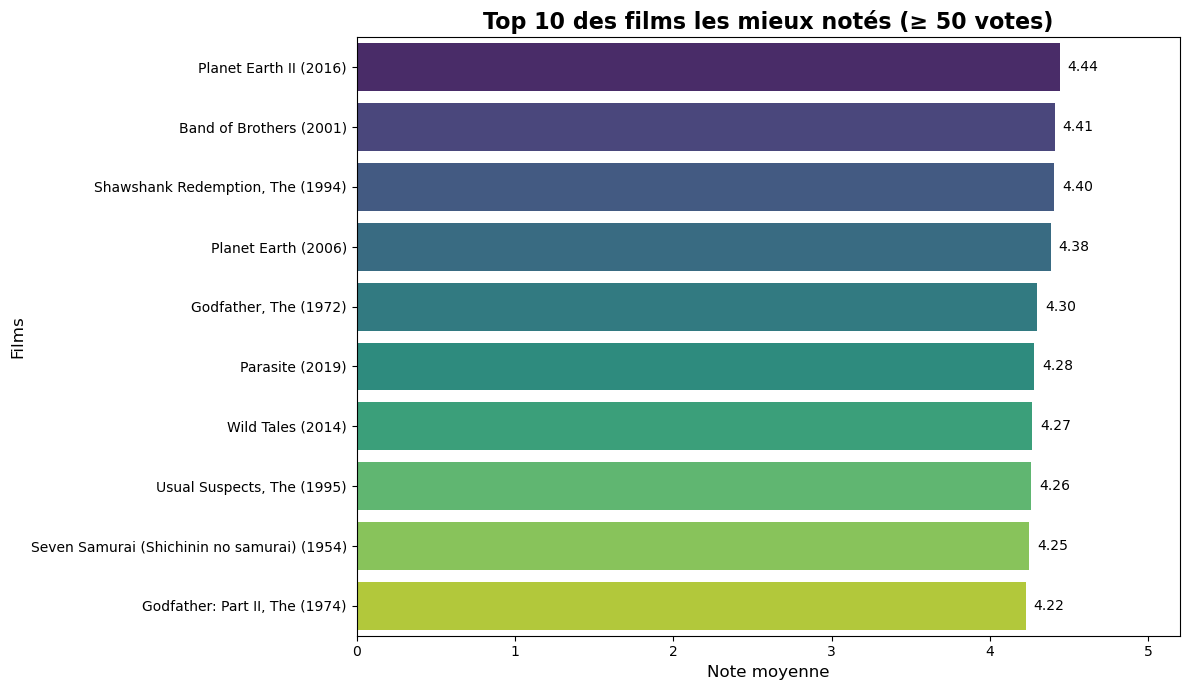

In [19]:
min_votes = 50
top_rated = ratings_merged.groupby('title').agg(
    avg_rating=('rating', 'mean'),  # Note moyenne
    num_ratings=('rating', 'count') # Nombre de votes
)

# Filtrer les films ayant au moins 'min_votes'
top_rated_filtered = top_rated[top_rated['num_ratings'] >= min_votes]

# Trier par note moyenne descendante et prendre le top 10
top_rated_filtered = top_rated_filtered.sort_values(by='avg_rating', ascending=False).head(10)

plt.figure(figsize=(12, 7)) # Agrandir la figure pour une meilleure lisibilité
ax = sns.barplot(y=top_rated_filtered.index, x=top_rated_filtered['avg_rating'], palette='viridis') # Ajout d'une palette de couleurs

plt.title(f"Top 10 des films les mieux notés (≥ {min_votes} votes)", fontsize=16, fontweight='bold')
plt.xlabel("Note moyenne", fontsize=12)
plt.ylabel("Films", fontsize=12)

# Ajouter les valeurs (notes moyennes) sur les barres
for p in ax.patches:
    ax.annotate(
        f'{p.get_width():.2f}', # Formater la note moyenne à 2 décimales
        (p.get_width() + 0.05, p.get_y() + p.get_height() / 2), # Positionnement à droite de la barre, centré verticalement
        ha='left', va='center', fontsize=10, color='black'
    )

# Optionnel : Tu pourrais aussi ajouter le nombre de votes à côté de la note si désiré
# Par exemple:
# for i, (title, row) in enumerate(top_rated_filtered.iterrows()):
#     ax.annotate(
#         f' ({int(row["num_ratings"])} votes)',
#         (row['avg_rating'] + 0.3, ax.patches[i].get_y() + ax.patches[i].get_height() / 2),
#         ha='left', va='center', fontsize=9, color='gray'
#     )

plt.xlim(0, 5.2) # Ajuster la limite de l'axe X pour laisser de la place aux annotations
plt.tight_layout() # Ajuster la mise en page
plt.show()

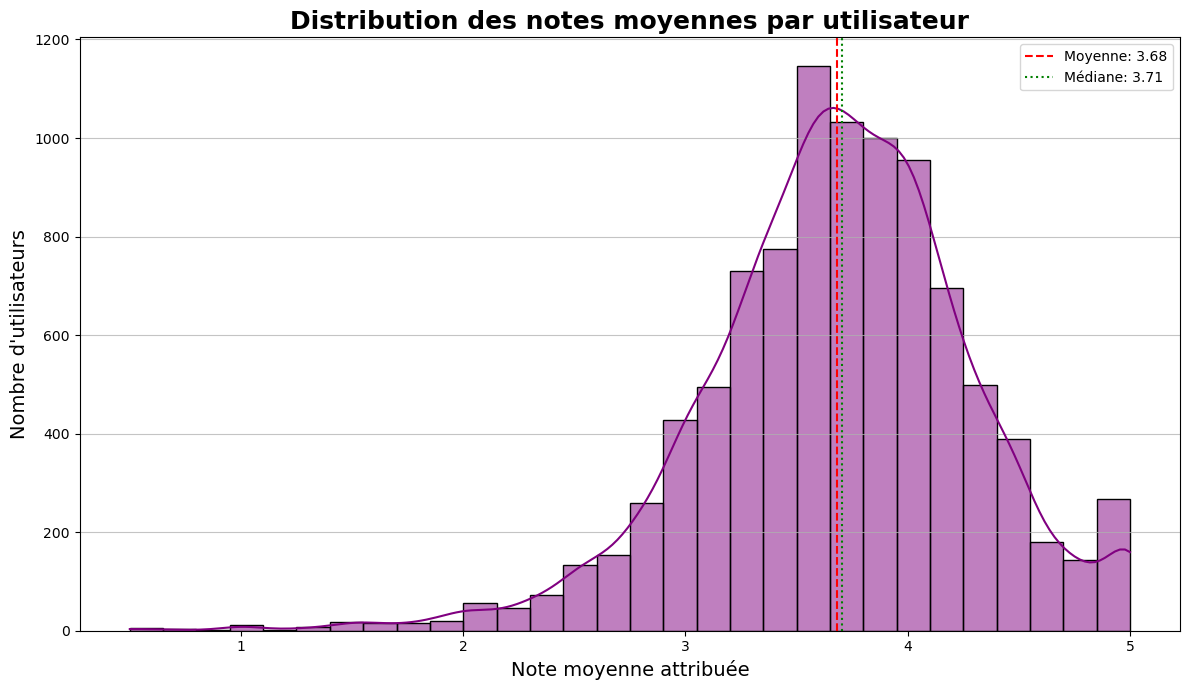

In [20]:
# Calcul de la note moyenne attribuée par chaque utilisateur
user_bias = ratings_merged.groupby('userId_new')['rating'].mean()

plt.figure(figsize=(12, 7)) # Taille de la figure légèrement agrandie
ax = sns.histplot(user_bias, bins=30, kde=True, color='purple', edgecolor='black') # Ajout de couleur et bordures pour les barres

plt.title("Distribution des notes moyennes par utilisateur", fontsize=18, fontweight='bold')
plt.xlabel("Note moyenne attribuée", fontsize=14) # Étiquette plus descriptive
plt.ylabel("Nombre d'utilisateurs", fontsize=14)

# Ajouter la moyenne et la médiane sur le graphique
mean_bias = user_bias.mean()
median_bias = user_bias.median()

plt.axvline(mean_bias, color='red', linestyle='--', label=f'Moyenne: {mean_bias:.2f}')
plt.axvline(median_bias, color='green', linestyle=':', label=f'Médiane: {median_bias:.2f}')
plt.legend(fontsize=10) # Afficher la légende pour les lignes

plt.grid(axis='y', alpha=0.75) # Ajout d'une grille légère sur l'axe Y
plt.tight_layout() # Ajuster la mise en page pour éviter les chevauchements
plt.show()

In [21]:
print("Nombre de NaN par colonne :\n", ratings_merged.isna().sum())


Nombre de NaN par colonne :
 userId         0
movieId        0
rating         0
title          0
genres         0
userId_new     0
movieId_new    0
dtype: int64


In [22]:
from sklearn.model_selection import train_test_split

def split_ratings(ratings, test_size=0.2):
    train_list = []
    test_list = []
    
    for user_id, group in ratings.groupby("userId"):
        if len(group) < 5:
            continue  # éviter les petits groupes

        train, test = train_test_split(group, test_size=test_size, random_state=42)
        train_list.append(train)
        test_list.append(test)

    return pd.concat(train_list), pd.concat(test_list)

ratings_train, ratings_test = split_ratings(ratings_merged, test_size=0.2)

In [23]:
# --- Calcul de la Sparcité pour ratings_train ---
nb_users_train = ratings_train['userId'].nunique()
nb_movies_train = ratings_train['movieId'].nunique()
nb_ratings_train = len(ratings_train)

# Calcul du nombre total de combinaisons possibles dans l'ensemble d'entraînement
# Note : C'est la taille maximale de la matrice si elle était dense pour ces utilisateurs et films spécifiques
total_possible_train = nb_users_train * nb_movies_train

# Gérer le cas où total_possible_train pourrait être zéro pour éviter une division par zéro
if total_possible_train == 0:
    sparsity_train = 1.0 # Ou une autre valeur appropriée si aucune combinaison n'est possible
else:
    sparsity_train = 1 - (nb_ratings_train / total_possible_train)

print(f"--- Sparcité de l'ensemble d'entraînement (ratings_train) ---")
print(f"Nombre d'utilisateurs uniques : {nb_users_train}")
print(f"Nombre de films uniques : {nb_movies_train}")
print(f"Nombre total de notes : {nb_ratings_train}")
print(f"Nombre de combinaisons User-Movie possibles : {total_possible_train}")
print(f"Taux de sparcité (train) : {sparsity_train:.4f} ({sparsity_train*100:.2f} %)")
print("-" * 50)

# --- Calcul de la Sparcité pour ratings_test ---
nb_users_test = ratings_test['userId'].nunique()
nb_movies_test = ratings_test['movieId'].nunique()
nb_ratings_test = len(ratings_test)

# Calcul du nombre total de combinaisons possibles dans l'ensemble de test
total_possible_test = nb_users_test * nb_movies_test

if total_possible_test == 0:
    sparsity_test = 1.0
else:
    sparsity_test = 1 - (nb_ratings_test / total_possible_test)

print(f"--- Sparcité de l'ensemble de test (ratings_test) ---")
print(f"Nombre d'utilisateurs uniques : {nb_users_test}")
print(f"Nombre de films uniques : {nb_movies_test}")
print(f"Nombre total de notes : {nb_ratings_test}")
print(f"Nombre de combinaisons User-Movie possibles : {total_possible_test}")
print(f"Taux de sparcité (test) : {sparsity_test:.4f} ({sparsity_test*100:.2f} %)")
print("-" * 50)

--- Sparcité de l'ensemble d'entraînement (ratings_train) ---
Nombre d'utilisateurs uniques : 8912
Nombre de films uniques : 23814
Nombre total de notes : 795486
Nombre de combinaisons User-Movie possibles : 212230368
Taux de sparcité (train) : 0.9963 (99.63 %)
--------------------------------------------------
--- Sparcité de l'ensemble de test (ratings_test) ---
Nombre d'utilisateurs uniques : 8912
Nombre de films uniques : 14036
Nombre total de notes : 203063
Nombre de combinaisons User-Movie possibles : 125088832
Taux de sparcité (test) : 0.9984 (99.84 %)
--------------------------------------------------


In [24]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings_train['user_idx'] = user_encoder.fit_transform(ratings_train['userId'])
ratings_train['movie_idx'] = movie_encoder.fit_transform(ratings_train['movieId'])

user_movie_sparse = csr_matrix((
    ratings_train['rating'],
    (ratings_train['user_idx'], ratings_train['movie_idx'])
))

movie_index_to_id = dict(enumerate(movie_encoder.inverse_transform(range(len(movie_encoder.classes_)))))


# Filtre colaboratif basé sur la mémoire (user - user)

In [25]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcul de la similarité cosinus
user_similarity = cosine_similarity(user_movie_sparse)
print("user_sililarity cosinus terminé")
#item_similarity = cosine_similarity(user_movie_sparse.T)
#print("item_sililarity cosinus terminé")

# Calcul de la distance de Manhattan (cityblock)
user_distance = pairwise_distances(user_movie_sparse, metric='cityblock')

#item_distance = pairwise_distances(user_movie_sparse.T, metric='cityblock')
#print("item_distance cityblock terminé")

# Transformer la distance en similarité (plus la distance est faible, plus la similarité est forte)
user_similarity_cityblock = 1 / (1 + user_distance)  # Évite division par zéro
print("user_distance cityblock terminé")
#item_similarity_cityblock = 1 / (1 + item_distance)

# Vérification des dimensions
print("Dimensions des matrices de similarité :")
print(f"Train user (cosinus) : {user_similarity.shape}")
#print(f"Train item (cosinus) : {item_similarity.shape}")
print(f"Train user (manhattan) : {user_similarity_cityblock.shape}")
#print(f"Train item (manhattan) : {item_similarity_cityblock.shape}")

user_sililarity cosinus terminé
user_distance cityblock terminé
Dimensions des matrices de similarité :
Train user (cosinus) : (8912, 8912)
Train user (manhattan) : (8912, 8912)


# Evaluation des modèles

In [26]:
def recommend_movies_user_user(user_id_original, user_movie_sparse, user_similarity, ratings_df, movies_df, user_encoder, movie_encoder, movie_index_to_id, n_recommendations=5):
    try:
        user_idx = user_encoder.transform([user_id_original])[0]
    except:
        print(f"Utilisateur {user_id_original} inconnu.")
        return []

    sim_scores = user_similarity[user_idx].copy()
    sim_scores[user_idx] = 0  # éviter auto-similarité

    weighted_scores = sim_scores @ user_movie_sparse
    norm_factors = np.array(sim_scores @ (user_movie_sparse > 0))
    norm_factors[norm_factors == 0] = 1
    scores = weighted_scores / norm_factors

    user_rated = user_movie_sparse[user_idx].toarray().flatten()
    scores[user_rated > 0] = 0  # ne pas recommander ce que l'utilisateur a déjà vu

    top_indices = scores.argsort()[::-1][:n_recommendations]
    recommended_movie_ids = [movie_index_to_id[i] for i in top_indices]

    return recommended_movie_ids  # liste simple d’IDs


In [27]:
def recommend_movies_user_user_sparse(*args, **kwargs):
    return recommend_movies_user_user(*args, **kwargs)

def recommend_movies_user_user_cityblock(*args, **kwargs):
    return recommend_movies_user_user(*args, **kwargs)


In [28]:
def precision_at_k(
    model_function, 
    user_ids, 
    ratings_test, 
    ratings_train, 
    user_movie_sparse, 
    user_similarity, 
    user_encoder, 
    movie_index_to_id, 
    movie_encoder, 
    movies_df, 
    k=5, 
    verbose=False
):
    precisions = []
    shown = 0

    for user_id in user_ids:
        # Vérifier que l'utilisateur est connu (dans le modèle)
        if user_id not in user_encoder.classes_:
            continue

        # Récupérer les films pertinents (rating >= 4 dans le test set)
        relevant_movies = ratings_test[
            (ratings_test["userId"] == user_id) & 
            (ratings_test["rating"] >= 4)
        ]["movieId"].values

        if len(relevant_movies) == 0:
            continue

        # Obtenir les recommandations
        recommended_ids = model_function(
            user_id_original=user_id,
            user_movie_sparse=user_movie_sparse,
            user_similarity=user_similarity,
            ratings_df=ratings_train,
            movies_df=movies_df,
            user_encoder=user_encoder,
            movie_encoder=movie_encoder,
            movie_index_to_id=movie_index_to_id,
            n_recommendations=k
        )

        if len(recommended_ids) == 0:
            continue

        # Calcul du nombre de recommandations pertinentes
        hits = len(set(recommended_ids) & set(relevant_movies))
        precisions.append(hits / k)

        # Affichage de debug (facultatif)
        if verbose and shown < 5:
            print(f"\nUtilisateur {user_id} — Precision@{k} = {hits}/{k}")
            print("Films recommandés :")
            for movie_id in recommended_ids:
                title = movies_df[movies_df["movieId"] == movie_id]["title"].values
                rating = ratings_test[
                    (ratings_test["userId"] == user_id) & 
                    (ratings_test["movieId"] == movie_id)
                ]["rating"].values
                note = rating[0] if len(rating) > 0 else "-"
                print(f"- {movie_id}: {title[0] if len(title) else '??'} — Note test : {note}")
            shown += 1

    return np.mean(precisions) if precisions else 0.0


In [29]:
# 1. Sélection des utilisateurs à tester (option : filtrer ceux qui ont au moins un film noté ≥ 4 dans le test)
users_with_good_ratings = ratings_test[ratings_test["rating"] >= 4]["userId"].unique()
users_to_test = [u for u in users_with_good_ratings if u in user_encoder.classes_]

print(f"{len(users_to_test)} utilisateurs à tester.")

# 2. Évaluation pour le modèle Cosine
precision_cosine = precision_at_k(
    model_function=recommend_movies_user_user_sparse,
    user_ids=users_to_test,
    ratings_test=ratings_test,
    ratings_train=ratings_train,
    user_movie_sparse=user_movie_sparse,
    user_similarity=user_similarity,
    user_encoder=user_encoder,
    movie_index_to_id=movie_index_to_id,
    movie_encoder=movie_encoder,
    movies_df=movies,
    k=5,
    verbose=True  # Met à False si tu veux un test silencieux
)

# 3. Évaluation pour le modèle Cityblock
precision_cityblock = precision_at_k(
    model_function=recommend_movies_user_user_cityblock,
    user_ids=users_to_test,
    ratings_test=ratings_test,
    ratings_train=ratings_train,
    user_movie_sparse=user_movie_sparse,
    user_similarity=user_similarity_cityblock,
    user_encoder=user_encoder,
    movie_index_to_id=movie_index_to_id,
    movie_encoder=movie_encoder,
    movies_df=movies,
    k=5,
    verbose=True
)

# 4. Affichage des résultats
print(f"\nPrecision@5 (Cosine)    : {precision_cosine:.4f}")
print(f"Precision@5 (Cityblock) : {precision_cityblock:.4f}")


8264 utilisateurs à tester.

Utilisateur 1 — Precision@5 = 0/5
Films recommandés :
- 103474: How to Make Money Selling Drugs (2013) — Note test : -
- 151593: Martyrs (2016) — Note test : -
- 106471: One Piece Film: Strong World (2009) — Note test : -
- 1812: Wide Awake (1998) — Note test : -
- 80599: Buster Keaton: A Hard Act to Follow (1987) — Note test : -

Utilisateur 2 — Precision@5 = 0/5
Films recommandés :
- 116742: Secret (2007) — Note test : -
- 167984: A Cinderella Christmas (2016) — Note test : -
- 100743: Eye In The Sky (Gun chung) (2007) — Note test : -
- 159427: Already Tomorrow in Hong Kong (2015) — Note test : -
- 115915: Better Tomorrow III: Love and Death in Saigon, A (1989) — Note test : -

Utilisateur 3 — Precision@5 = 0/5
Films recommandés :
- 204834: Danger Close: The Battle of Long Tan (2019) — Note test : -
- 95218: First Position (2011) — Note test : -
- 155109: Long Way Down (2010) — Note test : -
- 61013: Absolute Giganten (1999) — Note test : -
- 136890: East

In [30]:
def predict_rating(user_id, movie_id, user_movie_sparse, user_similarity, user_encoder, movie_encoder):
    try:
        user_idx = user_encoder.transform([user_id])[0]
        movie_idx = movie_encoder.transform([movie_id])[0]
    except:
        return None  # Utilisateur ou film inconnu

    sim_scores = user_similarity[user_idx]
    sim_scores[user_idx] = 0

    movie_ratings = user_movie_sparse[:, movie_idx].toarray().flatten()
    mask = movie_ratings > 0
    if np.sum(mask) == 0:
        return None  # Aucun voisin n'a noté ce film

    weighted_sum = np.dot(sim_scores[mask], movie_ratings[mask])
    sum_sim = np.sum(sim_scores[mask])
    if sum_sim == 0:
        return None

    return weighted_sum / sum_sim


In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_rmse(ratings_test, user_movie_sparse, user_similarity, user_encoder, movie_encoder):
    y_true = []
    y_pred = []

    for _, row in ratings_test.iterrows():
        user_id = row["userId"]
        movie_id = row["movieId"]
        true_rating = row["rating"]

        pred_rating = predict_rating(user_id, movie_id, user_movie_sparse, user_similarity, user_encoder, movie_encoder)
        if pred_rating is not None:
            y_true.append(true_rating)
            y_pred.append(pred_rating)

    return sqrt(mean_squared_error(y_true, y_pred)) if y_true else None


In [32]:
rmse_cosine = evaluate_rmse(ratings_test, user_movie_sparse, user_similarity, user_encoder, movie_encoder)
rmse_cityblock = evaluate_rmse(ratings_test, user_movie_sparse, user_similarity_cityblock, user_encoder, movie_encoder)

print(f"RMSE (Cosine)    : {rmse_cosine:.4f}")
print(f"RMSE (Cityblock) : {rmse_cityblock:.4f}")


RMSE (Cosine)    : 0.9645
RMSE (Cityblock) : 0.9747


# Recommandations

In [33]:
# Choisir un utilisateur à tester
user_id_test = 1

# Générer les 10 recommandations avec similarité Cosinus
recommended_movies_ids = recommend_movies_user_user_sparse(
    user_id_original=user_id_test,
    user_movie_sparse=user_movie_sparse,
    user_similarity=user_similarity,
    ratings_df=ratings,
    movies_df=movies,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
    movie_index_to_id=movie_index_to_id,
    n_recommendations=10
)

# Convertir les IDs en DataFrame avec les titres des films
recommended_movies_df = movies[movies['movieId'].isin(recommended_movies_ids)].copy()
recommended_movies_df = recommended_movies_df.sort_values(by='movieId')

# Affichage du résultat
print(f"Top 10 films recommandés à l'utilisateur {user_id_test} (Cosine Similarity) :")
display(recommended_movies_df.reset_index(drop=True))

Top 10 films recommandés à l'utilisateur 1 (Cosine Similarity) :


,movieId,title,genres
0,1812,Wide Awake (1998),Children|Comedy|Drama
1,2434,Down in the Delta (1998),Drama
2,72018,H.H. Holmes: America's First Serial Killer (2004),Crime|Documentary
3,80599,Buster Keaton: A Hard Act to Follow (1987),Documentary
4,103474,How to Make Money Selling Drugs (2013),Documentary
5,106471,One Piece Film: Strong World (2009),Action|Adventure|Animation|Comedy|Fantasy
6,112236,Broadway Idiot (2013),Documentary|Musical
7,139636,The Blue Elephant (2014),Drama|Horror|Mystery|Thriller
8,151593,Martyrs (2016),(no genres listed)
9,164005,Bad Cat (2016),Action|Animation|Comedy


In [34]:
# Choisir un utilisateur à tester
user_id_test = 1

# Générer les 10 recommandations avec similarité Cityblock
recommended_movies_ids = recommend_movies_user_user_sparse(
    user_id_original=user_id_test,
    user_movie_sparse=user_movie_sparse,
    user_similarity=user_similarity_cityblock,
    ratings_df=ratings,
    movies_df=movies,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
    movie_index_to_id=movie_index_to_id,
    n_recommendations=10
)

# Convertir les IDs en DataFrame avec les titres des films
recommended_movies_df = movies[movies['movieId'].isin(recommended_movies_ids)].copy()
recommended_movies_df = recommended_movies_df.sort_values(by='movieId')

# Affichage du résultat
print(f"Top 10 films recommandés à l'utilisateur {user_id_test} (Cityblock Distance) :")
display(recommended_movies_df.reset_index(drop=True))

Top 10 films recommandés à l'utilisateur 1 (Cityblock Distance) :


,movieId,title,genres
0,3495,Roadside Prophets (1992),Comedy|Drama
1,27297,Possible Worlds (2000),Crime|Drama|Mystery|Sci-Fi
2,95218,First Position (2011),Documentary
3,99731,Dabangg 2 (2012),Action|Comedy|Drama|Musical|Romance
4,104583,Logorama (2009),Action|Animation|Crime
5,133173,Barbie Mariposa and Her Butterfly Fairy Friend...,Animation|Children|Fantasy
6,148058,Talvar (2015),Drama|Mystery|Thriller
7,173429,Hasan Minhaj: Homecoming King (2017),Comedy
8,194068,The Panama Deception (1992),Documentary
9,259919,The Alpinist (2021),Documentary


In [35]:
# Recommandation basée sur prédiction explicite des notes
def top_k_predictions(user_id, user_movie_sparse, user_similarity, user_encoder, movie_encoder, movie_index_to_id, movies_df, k=10):
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except:
        print("Utilisateur inconnu.")
        return pd.DataFrame()

    user_seen_movies = user_movie_sparse[user_idx].toarray().flatten()
    unseen_movie_indices = np.where(user_seen_movies == 0)[0]
    
    movie_ids = []
    predicted_ratings = []

    for movie_idx in unseen_movie_indices:
        movie_id = movie_index_to_id[movie_idx]
        pred = predict_rating(user_id, movie_id, user_movie_sparse, user_similarity, user_encoder, movie_encoder)
        if pred is not None:
            movie_ids.append(movie_id)
            predicted_ratings.append(pred)

    # Créer DataFrame des prédictions
    pred_df = pd.DataFrame({
        'movieId': movie_ids,
        'predicted_rating': predicted_ratings
    })

    # Merge avec les titres de films
    pred_df = pred_df.merge(movies_df[['movieId', 'title']], on='movieId')
    pred_df = pred_df.sort_values(by='predicted_rating', ascending=False).head(k).reset_index(drop=True)
    
    return pred_df


In [36]:
user_id_test = 1

recommendations_df = top_k_predictions(
    user_id=user_id_test,
    user_movie_sparse=user_movie_sparse,
    user_similarity=user_similarity,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
    movie_index_to_id=movie_index_to_id,
    movies_df=movies,
    k=30
)

print(f"Top 30 films recommandés à l'utilisateur {user_id_test} (avec prédiction de note - Cosine) :")
display(recommendations_df)


Top 30 films recommandés à l'utilisateur 1 (avec prédiction de note - Cosine) :


,movieId,predicted_rating,title
0,72018,5.0,H.H. Holmes: America's First Serial Killer (2004)
1,103474,5.0,How to Make Money Selling Drugs (2013)
2,151593,5.0,Martyrs (2016)
3,106471,5.0,One Piece Film: Strong World (2009)
4,80599,5.0,Buster Keaton: A Hard Act to Follow (1987)
5,1812,5.0,Wide Awake (1998)
6,182871,5.0,The Cyborgs (2017)
7,7113,5.0,Cabeza de Vaca (1991)
8,212287,5.0,Memorable (2019)
9,139636,5.0,The Blue Elephant (2014)


In [37]:
user_id_test = 1

recommendations_df = top_k_predictions(
    user_id=user_id_test,
    user_movie_sparse=user_movie_sparse,
    user_similarity=user_similarity_cityblock,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
    movie_index_to_id=movie_index_to_id,
    movies_df=movies,
    k=30
)

print(f"Top 30 films recommandés à l'utilisateur {user_id_test} (avec prédiction de note - Cityblock) :")
display(recommendations_df)


Top 30 films recommandés à l'utilisateur 1 (avec prédiction de note - Cityblock) :


,movieId,predicted_rating,title
0,99731,5.0,Dabangg 2 (2012)
1,259919,5.0,The Alpinist (2021)
2,148058,5.0,Talvar (2015)
3,95218,5.0,First Position (2011)
4,173429,5.0,Hasan Minhaj: Homecoming King (2017)
5,196437,5.0,Bob Lazar: Area 51 and Flying Saucers (2018)
6,281058,5.0,Lady Chatterley's Lover (2022)
7,104583,5.0,Logorama (2009)
8,34032,5.0,Modigliani (2004)
9,3495,5.0,Roadside Prophets (1992)


#  Comparaison approfondie : Cosine Similarity vs Cityblock Distance

| **Critère**                    | **Cosine Similarity**                                                                 | **Cityblock (Manhattan) Distance**                                                  |
|-------------------------------|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| **Définition**                | Mesure l'angle (l'orientation) entre deux vecteurs                                     | Mesure la somme des différences absolues entre deux vecteurs                        |
| **Formule mathématique**      | ![cos(θ) = A·B / (Norme°2(A)·Norme°2(B))](https://latex.codecogs.com/svg.image?%5Ccos%28%5Ctheta%29%20%3D%20%5Cfrac%7BA%20%5Ccdot%20B%7D%7B%7C%7CA%7C%7C%20%5Ccdot%20%7C%7CB%7C%7C%7D) | ![D = Σ Norme°1(aᵢ - bᵢ)](https://latex.codecogs.com/svg.image?D%20%3D%20%5Csum%7C%20a_i%20-%20b_i%20%7C) |
| **Échelle prise en compte**   | ❌ Non : normalise les vecteurs                                                       | ✅ Oui : prend en compte la valeur absolue des différences                          |
| **Sensibilité aux notes**     | Faible : seuls les motifs sont importants (ex. tendances de vote)                     | Forte : deux notes proches sont considérées comme plus similaires                   |
| **Principe**                  | Deux utilisateurs sont similaires s’ils ont voté dans la **même direction**          | Deux utilisateurs sont similaires s’ils ont donné des **notes très proches**        |
| **Valeur de sortie**          | Entre **-1 et 1** (proximité vectorielle)                                             | Distance réelle (plus petite = plus proche)                                         |
| **Type de mesure**            | **Similarité** directe                                                                | **Distance** qu’on convertit souvent en similarité par : `1 / (1 + distance)`       |
| **Comportement typique**      | Regroupe les utilisateurs avec les **mêmes préférences relatives**                   | Regroupe les utilisateurs qui **notent très pareil** (mêmes niveaux)               |
| **Cas d'usage adapté**        | Recommandation basée sur **goûts similaires**                                          | Recommandation basée sur **proximité absolue des notations**                       |
| **Avantage principal**        | Ignore les biais de notation individuels (ex : note sévère ou indulgente)            | Capte mieux les cas où les utilisateurs sont très rigoureux ou similaires numériquement |
| **Inconvénient principal**    | Peut ignorer des écarts de valeur importants (ex : 2 vs 5)                            | Sensible aux biais de notation (note tout à 3 ou tout à 5)                          |
| **Popularité dans les reco** |  Très utilisée (standard pour filtrage collaboratif User-User / Item-Item)          | Moins fréquente, mais utile dans des modèles spécifiques                            |



#  Résumé des deux modèles de filtrage collaboratif (User-User)
| Modèle                                 | Type de distance                   | Fonction utilisée                        | Principe                                                                                                                                                                                                       |
| -------------------------------------- | ---------------------------------- | ---------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `recommend_movies_user_user_sparse`    | **Cosine Similarity**              | `cosine_similarity`                      | Compare l'**orientation** des vecteurs de notes entre utilisateurs (plutôt que leur valeur absolue). Deux utilisateurs sont similaires s’ils aiment/détestent les mêmes films, peu importe les notes exactes.  |
| `recommend_movies_user_user_cityblock` | **Cityblock (Manhattan) Distance** | `pairwise_distances(metric='cityblock')` | Compare la **distance absolue** entre les notes des utilisateurs. Plus la somme des différences est faible, plus les utilisateurs sont similaires. Transformée ensuite en similarité par `1 / (1 + distance)`. |


# Cas d’usage recommandé pour chaque modèle
| Cas d’usage                                                                                                      | Cosine Similarity                  | Cityblock (Manhattan) |
| ---------------------------------------------------------------------------------------------------------------- | ---------------------------------- | --------------------- |
| L'utilisateur note peu, mais les **tendances** générales sont importantes                                        | ✅ Très adapté                      | ❌ Moins bon           |
| On veut une comparaison **précise des notes** attribuées                                                         | ❌ Moins précis                     | ✅ Plus adapté         |
| Les utilisateurs ont des styles de notation très différents (certains notent sévèrement, d’autres généreusement) | ✅ Insensible à l’échelle des notes | ❌ Sensible aux écarts |
| Données très **sparse** (peu de films en commun entre utilisateurs)                                              | ✅ Robuste                          | ⚠️ Moins fiable       |
| Performance observée (dans ton cas)                                                                              | ✅ Meilleure précision et RMSE      | ❌ Moins bon résultat  |


# Sauvegarde des arguments et du modèle.

In [38]:
import joblib
import pickle
from scipy.sparse import save_npz

# Encoders
joblib.dump(user_encoder, 'user_encoder.pkl')
joblib.dump(movie_encoder, 'movie_encoder.pkl')

# Matrice user-item
save_npz('user_movie_sparse.npz', user_movie_sparse)

# Similarité utilisateur
np.save('user_similarity.npy', user_similarity)

# movie_index_to_id
with open('movie_index_to_id.pkl', 'wb') as f:
    pickle.dump(movie_index_to_id, f)

# movies_df
#movies.to_csv('movies_df.csv', index=False)


#  Utilisation externe

In [39]:
def load_recommendation_model():
    import joblib, pickle, pandas as pd, numpy as np
    from scipy.sparse import load_npz

    return {
        "user_encoder": joblib.load('user_encoder.pkl'),
        "movie_encoder": joblib.load('movie_encoder.pkl'),
        "user_movie_sparse": load_npz('user_movie_sparse.npz'),
        "user_similarity": np.load('user_similarity.npy'),
        "movie_index_to_id": pickle.load(open('movie_index_to_id.pkl', 'rb')),
        "movies_df": pd.read_csv('movies.csv')
    }


In [40]:
model = load_recommendation_model()
recommendations = top_k_predictions(
    user_id=42,
    **model,
    k=10
)


In [41]:
recommendations

,movieId,predicted_rating,title
0,155109,5.0,Long Way Down (2010)
1,32139,5.0,"Agony and the Ecstasy, The (1965)"
2,6511,5.0,Jesus (1979)
3,193201,5.0,RX 100 (2018)
4,192713,5.0,Compulsion (2018)
5,192827,5.0,Jawani Phir Nahi Ani 2 (2018)
6,60887,5.0,Blindsight (2006)
7,114620,5.0,Alice (2005)
8,61013,5.0,Absolute Giganten (1999)
9,82420,5.0,Pray the Devil Back to Hell (2008)
